# MODFLOW API Paper

# Create Trimesh Grid for McDonald Valley Problem for the "Optimization of groundwater withdrawals" example

This notebook can be used to create the MODFLOW 6 datasets used by the "Optimization of groundwater withdrawals" example, as reported in the MODFLOW 6 API paper (in progress). This notebook should be run prior to running the `optimize_mv_api.ipynb` notebook.

## Prerequisites
To run the simulation and process the results, the following publicly available software and data are required:

* __libmf6.dll__ (Windows) or __libmf6.so__ (linux or MacOS) pre-compiled dynamic-link library (dll)/shared object (so) and available from https://github.com/MODFLOW-USGS/executables. The operating specific pre-compiled dll/so should be installed in the `bin` subdirectory at the same level as the subdirectory containing this Jupyter Notebook (`../bin/`). 
* __mf6.exe__ (Windows) or __mf6__ (linux or MacOS) pre-compiled application and available from https://github.com/MODFLOW-USGS/executables. The operating specific pre-compiled application should be installed in the `bin` subdirectory at the same level as the subdirectory containing this Jupyter Notebook (`../bin/`). 
https://github.com/Deltares/xmipy.
* __flopy__ is a python package that can be used to build, run, and post-process MODFLOW 6 models. The source is available at https://github.com/modflowpy/flopy and the package can be installed from PyPI using `pip install flopy` or conda using `conda install flopy`.
    
## Building the McDonald Valley MODFLOW 6 datasets

We start by importing the necessary packages:

In [ ]:
import os
import sys
import numpy as np
import scipy.interpolate as sci
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import rasterio
from shapely.geometry import LineString

import flopy
from flopy.utils.gridgen import Gridgen
import flopy.plot.styles as styles

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))


_Define the name of the executable_

In [ ]:
exe_name = "mf6"
if sys.platform == "win32":
    exe_name += ".exe"

## Load external data

In [ ]:
kaq = flopy.utils.Raster.load("./data/k_aq.asc")
kclay = flopy.utils.Raster.load("./data/k_clay.asc")
top_base = flopy.utils.Raster.load("./data/top.asc")
bot = flopy.utils.Raster.load("./data/bottom.asc")

## Create Structured Grid

In [ ]:
nlay = 5
nrow = 40
ncol = 25
shape2d = (nrow, ncol)
shape3d = (nlay, nrow, ncol)
delr, delc = 500.0, 500.0
delrs = np.ones(ncol, dtype=np.float32) * delr
delcs = np.ones(nrow, dtype=np.float32) * delc
top = top_base.get_array(1)
botm = np.zeros(shape3d, dtype=np.float32)
botm[0] = -5.0
botm[1] = -50.0
botm[2] = -51.0
botm[3] = -100.0
botm[4] = bot.get_array(1)

Build structured model grid

In [ ]:
struct_grid = flopy.discretization.StructuredGrid(
    nlay=1,
    nrow=nrow,
    ncol=ncol,
    delr=delrs,
    delc=delcs,
    top=top,
    botm=botm[0].reshape((1, nrow, ncol)),
)

## Create shapely line for SFR

In [ ]:
xc, yc = struct_grid.xycenters
yv = struct_grid.yvertices
xc.shape, yc.shape, yv.shape

In [ ]:
x0 = x1 = xc[8]
y0, y1 = yv[22, 8] - 0.5 * delc, yv[-1, 8]
x0, y0, y0, y1

In [ ]:
straight_river = LineString([(x0, y0), (x1, y1)])

In [ ]:
ixs = flopy.utils.GridIntersect(struct_grid, method="structured")
result = ixs.intersect(straight_river)

In [ ]:
result

In [ ]:
result["lengths"].sum()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 12))
ax.axis("equal")
extents = (x0 - 10, x1 + 10, y1, y0 + 200)
mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax, extent=extents)
mm.plot_grid(lw=0.5, color="black")
ixs.plot_linestring(result, ax=ax)

## Read the Trimesh File into Python

In [ ]:
fname = "./data/TriMesh_with_densified_contours.exp"
with open(fname, "r") as f:
    lines = f.readlines()

# read vertex info into a structured array
vtmp = [line.strip().split()[1:] for line in lines if line.startswith("N")]
dtype = [
    ("ivert", int),
    ("x", float),
    ("y", float),
    ("label", "|S10"),
    ("ibound", int),
    ("elev", float),
]
vertices = np.empty((len(vtmp)), dtype=dtype)
for i, line in enumerate(vtmp):
    for j, val in enumerate(line):
        vertices[i][j] = val

# read element info into a structured array
etmp = [line.strip().split()[1:] for line in lines if line.startswith("E")]
dtype = [
    ("icell", int),
    ("iv1", int),
    ("iv2", int),
    ("iv3", int),
    ("label", "|S10"),
    ("ibound", int),
    ("elev", float),
]
cells = np.empty((len(etmp)), dtype=dtype)
for i, line in enumerate(etmp):
    for j, val in enumerate(line):
        cells[i][j] = val

In [ ]:
verts = []
for ivert, x, y, label, ibound, elev in vertices:
    verts.append([x, y])
verts = np.array(verts, dtype=float)

iverts = []
for i, iv1, iv2, iv3, s, ibound, elev in list(cells):
    iverts.append([iv3 - 1, iv2 - 1, iv1 - 1])

ncpl = len(iverts)
nvert = verts.shape[0]

## Calculate Centroids

In [ ]:
# centroid and area array
from flopy.utils.cvfdutil import centroid_of_polygon, area_of_polygon

xcyc = np.empty((ncpl, 2), dtype=float)
area = np.empty((ncpl), dtype=float)
for icell in range(ncpl):
    vlist = [(verts[ivert, 0], verts[ivert, 1]) for ivert in iverts[icell]]
    xcyc[icell, 0], xcyc[icell, 1] = centroid_of_polygon(vlist)
    area[icell] = abs(area_of_polygon(*zip(*vlist)))

In [ ]:
# make temporary vertex grid for plotting and intersecting
vertices = []
for i in range(nvert):
    vertices.append((i, verts[i, 0], verts[i, 1]))

cell2d = []
for i in range(ncpl):
    cell2d.append([i, xcyc[i, 0], xcyc[i, 1], 3] + [iv for iv in iverts[i]])

vg_temp = flopy.discretization.VertexGrid(
    vertices=vertices, cell2d=cell2d, nlay=1, ncpl=len(cell2d)
)

Plot the DISV grid

In [ ]:
grid_verts = vg_temp.verts
xcc, ycc = vg_temp.xyzcellcenters[:2]

In [ ]:
with styles.USGSMap():
    fig = plt.figure(figsize=(8, 12))
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=vg_temp)
    mm.plot_grid()
    plt.plot(xcc, ycc, "ko", markersize=1.0)
    plt.plot(grid_verts[:, 0], grid_verts[:, 1], "rs", markersize=1.5)

## Intersect the Grid with the Property Arrays

In [ ]:
kaq_tm = kaq.resample_to_grid(
    vg_temp,
    band=kaq.bands[0],
    method="nearest",
    extrapolate_edges=True,
)

In [ ]:
with styles.USGSMap():
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 2, 1, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax)
    mm.plot_array(kaq.get_array(1), cmap="jet")

    ax = fig.add_subplot(1, 2, 2, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=vg_temp, ax=ax)
    mm.plot_array(kaq_tm, cmap="jet")

In [ ]:
kclay_tm = kclay.resample_to_grid(
    vg_temp,
    band=kclay.bands[0],
    method="nearest",
)

In [ ]:
with styles.USGSMap():
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 2, 1, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax)
    mm.plot_array(kclay.get_array(1), cmap="jet")

    ax = fig.add_subplot(1, 2, 2, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=vg_temp, ax=ax)
    mm.plot_array(kclay_tm, cmap="jet")

In [ ]:
top_tm = top_base.resample_to_grid(
    vg_temp, band=top_base.bands[0], method="linear", extrapolate_edges=True
)
top_tm[cells["ibound"] == 3] = 10.0

In [ ]:
with styles.USGSMap():
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 2, 1, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax)
    v = mm.plot_array(top_base.get_array(1), cmap="jet")
    mm.plot_grid(lw=0.5, color="0.5")
    ax.plot(
        struct_grid.xcellcenters,
        struct_grid.ycellcenters,
        "ko",
        markersize=0.75,
    )
    plt.colorbar(v, ax=ax, shrink=0.5)

    ax = fig.add_subplot(1, 2, 2, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=vg_temp, ax=ax)
    v = mm.plot_array(top_tm, cmap="jet", masked_values=[1e30])
    mm.plot_grid(lw=0.5, color="0.5")
    plt.colorbar(v, ax=ax, shrink=0.5);

In [ ]:
bot_tm = bot.resample_to_grid(
    vg_temp, band=bot.bands[0], method="linear", extrapolate_edges=True
)

In [ ]:
with styles.USGSMap():
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(1, 2, 1, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=struct_grid, ax=ax)
    v = mm.plot_array(bot.get_array(1), cmap="jet")
    mm.plot_grid(lw=0.5, color="0.5")
    ax.plot(
        struct_grid.xcellcenters,
        struct_grid.ycellcenters,
        "ko",
        markersize=0.75,
    )
    plt.colorbar(v, ax=ax, shrink=0.5)

    ax = fig.add_subplot(1, 2, 2, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=vg_temp, ax=ax)
    v = mm.plot_array(bot_tm, cmap="jet", masked_values=[1e30])
    mm.plot_grid(lw=0.5, color="0.5")
    plt.colorbar(v, ax=ax, shrink=0.5);

## Intersect the Features with the Grid

In [ ]:
ibd = cells["ibound"]
top = cells["elev"]

with styles.USGSMap():
    fig = plt.figure(figsize=(15, 15), constrained_layout=True)
    ax = fig.add_subplot(1, 2, 1, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=vg_temp, ax=ax)
    mm.plot_array(ibd, cmap="jet")

    ax = fig.add_subplot(1, 2, 2, aspect="equal")
    mm = flopy.plot.PlotMapView(modelgrid=vg_temp, ax=ax)
    v = mm.plot_array(top_tm, cmap="jet")
    cs = mm.contour_array(top_tm, colors="white", levels=np.arange(5, 65, 5))
    ax.clabel(cs, inline=1, fmt="%1.0f", fontsize=10)
    cb = plt.colorbar(v, shrink=0.5)

#### Intersect straight river with grid

In [ ]:
ixs = flopy.utils.GridIntersect(vg_temp, method="vertex")
vg_result = ixs.intersect(straight_river, sort_by_cellid=False)

In [ ]:
vg_result.shape, vg_result["lengths"].sum()

In [ ]:
vg_result.sort(order="vertices")
vg_result.shape, vg_result["lengths"].sum()

In [ ]:
xcv, ycv = vg_temp.xcellcenters, vg_temp.ycellcenters
xcv.shape, ycv.shape

In [ ]:
vg_temp.ncpl

## Set forcing data

In [ ]:
rainfall = 0.00821918
evaporation = 0.0062296
net_rainfall = 0.003641

## Build SFR, LAK, DRN, and WEL datasets

SFR datasets

In [ ]:
sfr_unit_conversion = 1.486 * 86400.0

In [ ]:
sfr_plt_array = np.zeros(vg_temp.ncpl, dtype=int)

In [ ]:
sfr_nodes = np.arange(0, vg_result.shape[0])
gwf_nodes = vg_result["cellids"][::-1]
sfr_lengths = vg_result["lengths"][::-1]

In [ ]:
total_cond = 1800000.0
sfr_width = 10.0
sfr_bedthick = 1.0
sfr_hk = total_cond * sfr_bedthick / (sfr_width * sfr_lengths.sum())
sfr_hk

In [ ]:
b0, b1 = -0.3, -2.05
sfr_slope = -0.0002
cum_dist = np.zeros(sfr_nodes.shape, dtype=float)
cum_dist[0] = 0.5 * sfr_lengths[0]
for idx in range(1, sfr_nodes.shape[0]):
    cum_dist[idx] = cum_dist[idx - 1] + 0.5 * (
        sfr_lengths[idx - 1] + sfr_lengths[idx]
    )
sfr_bot = b0 + sfr_slope * cum_dist
cum_dist[-1], sfr_lengths.sum(), sfr_lengths[-1], sfr_bot[-1]

In [ ]:
sfr_conn = []
for idx, node in enumerate(sfr_nodes):
    iconn = [node]
    if idx > 0:
        iconn.append(sfr_nodes[idx - 1])
    if idx < sfr_nodes.shape[0] - 1:
        iconn.append(-sfr_nodes[idx + 1])
    sfr_conn.append(iconn)

In [ ]:
# <rno> <cellid(ncelldim)> <rlen> <rwid> <rgrd> <rtp> <rbth> <rhk> <man> <ncon> <ustrf> <ndv>
sfrpak_data = []
for idx, (cellid, rlen, rtp) in enumerate(
    zip(gwf_nodes, sfr_lengths, sfr_bot)
):
    sfr_plt_array[cellid] = 1
    sfrpak_data.append(
        (
            idx,
            (
                0,
                cellid,
            ),
            rlen,
            sfr_width,
            -sfr_slope,
            rtp,
            sfr_bedthick,
            sfr_hk,
            0.030,
            (len(sfr_conn[idx]) - 1),
            1.0,
            0,
        )
    )
sfrpak_data[-2:]

In [ ]:
sfr_spd = [(node, "rainfall", rainfall) for node in sfr_nodes] + [
    (node, "evaporation", evaporation) for node in sfr_nodes
]

LAK datasets

In [ ]:
lak_length_conversion = 3.28081
lak_time_conversion = 86400.0

In [ ]:
iriv = 1
iwel = 2
ilak = 3

lake_ic = 11.3
idx = np.where(cells["ibound"] == ilak)

chdspd = [
    [(0, ip1 - 1), 11.0]
    for ip1, iv1, iv2, iv3, txt, ibound, elev in cells[idx]
]

lake_map = np.ones(ncpl, dtype=int) * -1
lake_map[idx] = 0

(idomain, lakpak_dict, lak_connections) = flopy.mf6.utils.get_lak_connections(
    vg_temp,
    lake_map,
    bedleak=0.05,
)

lakpak_data = [(0, lake_ic, lakpak_dict[0])]
lake_spd = [
    (0, "rainfall", rainfall),
    (0, "evaporation", evaporation),
]

In [ ]:
lake_ic, lakpak_data

In [ ]:
lak_connections[0:10]

DRN datasets

Area of a triangle from 3 points

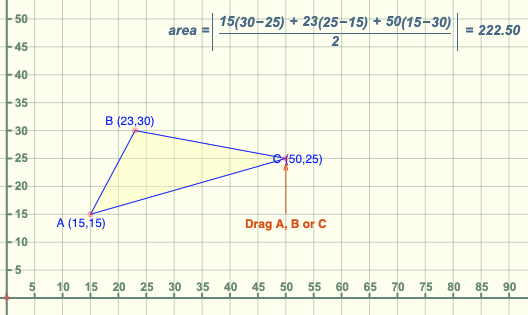

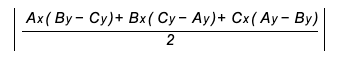


In [ ]:
areas = []
for idx in range(vg_temp.ncpl):
    (xa, ya), (xb, yb), (xc, yc) = vg_temp.get_cell_vertices(idx)
    area = abs((xa * (yb - yc) + xb * (yc - ya) + xc * (ya - yb)) / 2)
    areas.append(area)

In [ ]:
(xa, ya), (xb, yb), (xc, yc) = vg_temp.get_cell_vertices(0)
xa, xb, xc

In [ ]:
drn_kv = 0.1
drn_depth = 1.0
drn_spd = []
for idx, elev in enumerate(top_tm):
    if idomain[0, idx] > 0:
        cond = drn_kv * areas[idx] / drn_depth
        drn_spd.append([(0, idx), elev, cond, -drn_depth])
drn_spd[:10]

WEL datasets

In [ ]:
# first well is Virginia City well site 2
# second well is Reilly well
# third well is Virginia City well site 1
idx = cells["ibound"] == iwel
boundname = ["VC2", "Reilly", "VC1"]
rates = [-67000.0, -268000.0, -268000.0]
welspd = [
    [(4, ip1 - 1), 0.0] for ip1, iv1, iv2, iv3, txt, ibound, elev in cells[idx]
]
welspd = [
    [cellid, rates[i], boundname[i]] for i, (cellid, rate) in enumerate(welspd)
]
welspd

## Plot a series of grids

In [ ]:
def add_subdomain(ax, xll, xur, yll, yur, lw=0.75, color="cyan", text="B"):
    x = [xll, xll, xur, xur, xll]
    y = [yll, yur, yur, yll, yll]
    ax.plot(x, y, lw=lw, color=color)
    styles.add_text(
        ax=ax,
        text=text,
        x=xll,
        y=yur,
        color=color,
        transform=False,
        ha="right",
        va="bottom",
        italic=False,
    )

In [ ]:
def add_nodes(ax, xll, xur, yll, yur, edge=10.0, text_offset=2.0):
    for idx, (x, y) in enumerate(zip(xcv, ycv)):
        if x > xll and x < xur and y > yll and y < yur:
            ax.plot(x, y, marker=".", markersize=6, color="black")
            if (
                x > xll + edge
                and x < xur - edge
                and y > yll
                and y < yur - edge
            ):
                xt = x
                yt = y + text_offset
                styles.add_text(
                    ax=ax,
                    x=xt,
                    y=yt,
                    text="{}".format(idx),
                    bold=False,
                    transform=False,
                    ha="center",
                    va="bottom",
                    fontsize=6,
                )

In [ ]:
well_locx, well_locy = [], []
for cellid, q, boundname in welspd:
    k, node = cellid
    x, y = vg_temp.xcellcenters[node], vg_temp.ycellcenters[node]
    well_locx.append(x)
    well_locy.append(y)
well_locx, well_locy

In [ ]:
dv = 100.0
cmap = "viridis"

with styles.USGSMap():
    fig = plt.figure(figsize=(10, 8), constrained_layout=True)
    gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    ax0 = fig.add_subplot(gs[:, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[1, 1], sharex=ax1)

    ax = ax0
    ax.set_aspect("equal", "box")
    mm = flopy.plot.PlotMapView(modelgrid=vg_temp, ax=ax)
    #     mm.plot_grid(lw=0.5, color="black")
    mm.plot_array(
        idomain,
        masked_values=[
            1,
        ],
        lw=0.5,
        color="black",
        cmap="jet",
    )
    ixs.plot_linestring(vg_result, ax=ax, linewidth=2.25, color="cyan")
    ax.plot(well_locx, well_locy, marker=".", color="red", markersize=10, lw=0)
    ax.set_xlabel("x-coordinate")
    ax.set_ylabel("y-coordinate")
    styles.heading(ax=ax, idx=0)

    ax = ax1
    ax.set_aspect("equal", "box")
    plt.setp(ax.get_xticklabels(), visible=False)
    iw = 42.85  # 44.2
    xll, xur = x0 - dv, x1 + dv
    yll, yur = y1 + iw * 2 * dv, y1 + (iw + 1) * 2 * dv
    add_subdomain(ax0, xll, xur, yll, yur, text="B")
    mm = flopy.plot.PlotMapView(
        modelgrid=vg_temp, ax=ax, extent=(xll, xur, yll, yur)
    )
    mm.plot_array(sfr_plt_array, color="blue", alpha=0.5, masked_values=[0])
    mm.plot_grid(lw=0.5, color="black")
    ixs.plot_linestring(vg_result, ax=ax, linewidth=2.25, color="cyan")
    add_nodes(ax, xll, xur, yll, yur)
    ax.set_xlabel("x-coordinate")
    ax.set_ylabel("y-coordinate")
    styles.heading(ax=ax, idx=1)

    ax = ax2
    ax.set_aspect("equal", "box")
    iw = 0.0  # 44.2
    xll, xur = x0 - dv, x1 + dv
    yll, yur = y1 + iw * 2 * dv, y1 + (iw + 1) * 2 * dv
    add_subdomain(ax0, xll, xur, yll, yur, text="C")
    mm = flopy.plot.PlotMapView(
        modelgrid=vg_temp, ax=ax, extent=(xll, xur, yll, yur)
    )
    mm.plot_array(sfr_plt_array, color="blue", alpha=0.5, masked_values=[0])
    mm.plot_grid(lw=0.5, color="black")
    ixs.plot_linestring(vg_result, ax=ax, lw=2.25, color="cyan")
    add_nodes(ax, xll, xur, yll, yur)
    ax.set_xlabel("x-coordinate")
    ax.set_ylabel("y-coordinate")
    styles.heading(ax=ax, idx=2)

    fpth = "figures/river_discretization.png"
    plt.savefig(fpth, dpi=300);

## Build the Model

In [ ]:
ws = "./temp/mvmodel"
name = "mv"
sim = flopy.mf6.MFSimulation(sim_ws=ws, sim_name=name, exe_name=exe_name)
tdis = flopy.mf6.ModflowTdis(sim, time_units="days")
ims = flopy.mf6.ModflowIms(
    sim,
    print_option="all",
    complexity="complex",
    # under_relaxation="simple",
    # under_relaxation_gamma=0.90,
    outer_dvclose=1e-3,
    outer_maximum=200,
    linear_acceleration="bicgstab",
    inner_dvclose=1e-4,
    inner_maximum=200,
    rcloserecord="1e-2 strict",
    #     preconditioner_levels=8,
    #     preconditioner_drop_tolerance=1e-4,
)
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname=name,
    save_flows=True,
    newtonoptions="NEWTON UNDER_RELAXATION",
)
dis = flopy.mf6.ModflowGwfdisv(
    gwf,
    nlay=nlay,
    ncpl=vg_temp.ncpl,
    nvert=vg_temp.nvert,
    top=top_tm,
    botm=[-5, -50, -51, -100.0, bot_tm],
    vertices=vertices,
    cell2d=cell2d,
)
ic = flopy.mf6.ModflowGwfic(gwf, strt=11.0)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    xt3doptions=True,
    save_specific_discharge=True,
    icelltype=[1, 0, 0, 0, 0],
    k=[kaq_tm, kaq_tm, kclay_tm, kaq_tm, kaq_tm],
    k33=[0.25 * kaq_tm, 0.25 * kaq_tm, kclay_tm, 0.25 * kaq_tm, 0.25 * kaq_tm],
)
# chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=chdspd)
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rainfall)
evt = flopy.mf6.ModflowGwfevta(
    gwf, surface=cells["elev"], rate=evaporation, depth=1.0
)
# riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)
wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data=welspd, boundnames=True)
drn = flopy.mf6.ModflowGwfdrn(
    gwf,
    auxiliary=["depth"],
    auxdepthname="depth",
    stress_period_data=drn_spd,
)
sfr = flopy.mf6.ModflowGwfsfr(
    gwf,
    print_stage=True,
    print_flows=True,
    unit_conversion=sfr_unit_conversion,
    stage_filerecord="{}.sfr.stage.bin".format(name),
    budget_filerecord="{}.sfr.cbc".format(name),
    nreaches=len(sfrpak_data),
    packagedata=sfrpak_data,
    connectiondata=sfr_conn,
    perioddata=sfr_spd,
)
lak = flopy.mf6.ModflowGwflak(
    gwf,
    time_conversion=lak_time_conversion,
    length_conversion=lak_length_conversion,
    print_stage=True,
    print_flows=True,
    stage_filerecord="{}.lak.stage.bin".format(name),
    budget_filerecord="{}.lak.cbc".format(name),
    nlakes=1,
    packagedata=lakpak_data,
    connectiondata=lak_connections,
    perioddata=lake_spd,
)
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=name + ".hds",
    budget_filerecord=name + ".bud",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("BUDGET", "ALL")],
)
# write the model datasets
sim.write_simulation()

# run the model
success = sim.run_simulation()